In [1]:
from __future__ import division, print_function
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve

## Create data for example

Synthetic two moons data set. 100*known_labels_ratio % of the samples from one of the moons keep their labels, the rest of the samples are considered unlabeled.

Amount of labeled samples: 300


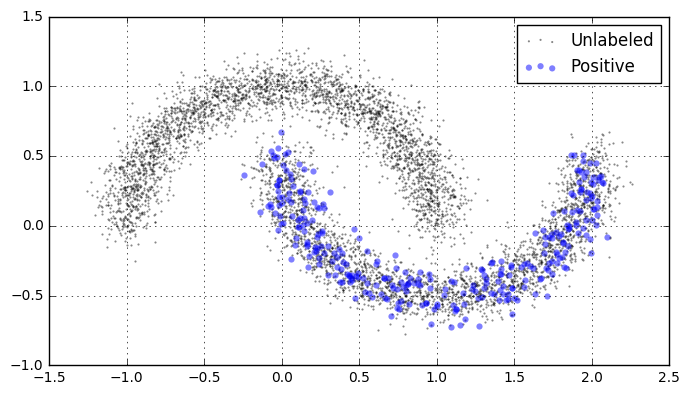

In [2]:
N = 6000
known_labels_ratio = 0.1
X, y = make_moons(n_samples=N, noise=0.1, shuffle=True)
rp = np.random.permutation(int(N/2))
data_P = X[y==1][rp[:int(len(rp)*known_labels_ratio)]]
data_U = np.concatenate((X[y==1][rp[int(len(rp)*known_labels_ratio):]], X[y==0]), axis=0)
print("Amount of labeled samples: %d" % (data_P.shape[0]))
plt.figure(figsize=(8, 4.5))
plt.scatter(data_U[:, 0], data_U[:, 1], c='k', marker='.', linewidth=1, s=1, alpha=0.5, label='Unlabeled')
plt.scatter(data_P[:, 0], data_P[:, 1], c='b', marker='o', linewidth=0, s=20, alpha=0.5, label='Positive')
plt.grid()
plt.legend()

## Transductive PU learning

An ensemble of decision trees are trained using bagging. Each tree is trained with the whole positive set and a bootstrapped sample of the unlabeled set. Each tree evaluates its out-of-the-bag (oob) samples and makes a prediction. The predictions are averaged essentially transducing the labels to the whole unlabeled set. 

The sensible parameters are
- T: The number of weak learners of the ensemble
- K: The size of the random bootstrap sample
- The parameters of the weak learner, in this case the depth of the trees, criterion, number of features, etc.

Note: In the original paper the weak learner of choice was linear support vector machine.

In [3]:
NP = data_P.shape[0]
NU = data_U.shape[0]

T = 1000
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U[bootstrap_sample, :]), axis=0)
    # Train model
    model = DecisionTreeClassifier(max_depth=None, max_features=None, 
                                   criterion='gini', class_weight='balanced')
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

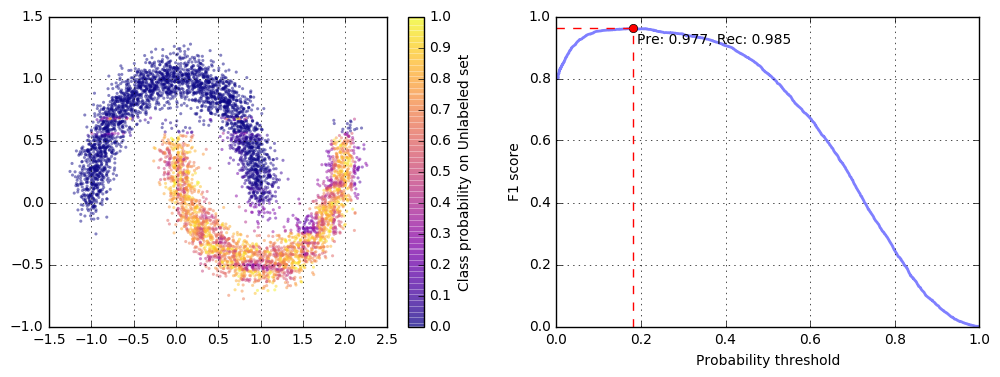

In [4]:
# Plot the class probabilities for the unlabeled samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sp= ax1.scatter(data_U[:, 0], data_U[:, 1], c=predict_proba, 
                linewidth=0, s=5, alpha=0.5, cmap=plt.cm.plasma, label='unlabeled')
plt.grid()
plt.colorbar(sp, label='Class probability on Unlabeled set')

true_labels = np.zeros(shape=(data_U.shape[0]))
true_labels[:int(len(rp)*(1.0-known_labels_ratio))] = 1.0
precision, recall, th = precision_recall_curve(true_labels, predict_proba)
ax2 = fig.add_subplot(1, 2, 2)
f1s = precision[:-1]*recall[:-1]
ax2.plot(th, f1s, linewidth=2, alpha=0.5)
best_th = np.argmax(f1s)
ax2.plot(th[best_th], f1s[best_th], c='r', marker='o')
ax2.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
ax2.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax2.annotate('Pre: %0.3f, Rec: %0.3f' %(precision[best_th], recall[best_th]), 
             xy=(th[best_th]+ 0.01, f1s[best_th]-0.05))
ax2.set_ylabel('F1 score')
ax2.set_xlabel('Probability threshold')
plt.grid()